In [3]:
# first lets import everything
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

In [4]:
# First, here's our encoder network, mapping inputs to our latent distribution parameters:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [6]:
#We can use these parameters to sample new similar points from the latent space:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [7]:
# Finally, we can map these sampled latent points back to reconstructed inputs:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [8]:
# We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [9]:
# We train our VAE on MNIST digits:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 224.3335 - val_loss: 167.9137
Epoch 2/100
1875/1875 [==============================] - 5s 2ms/step - loss: 166.4619 - val_loss: 163.2840
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 162.5982 - val_loss: 161.0678
Epoch 4/100
1875/1875 [==============================] - 5s 2ms/step - loss: 160.3222 - val_loss: 159.1680
Epoch 5/100
1875/1875 [==============================] - 5s 2ms/step - loss: 158.4762 - val_loss: 157.9066
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 157.1885 - val_loss: 156.3514
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 155.9209 - val_loss: 155.2428
Epoch 8/100
1875/1875 [==============================] - 5s 2ms/step - loss: 154.1757 - val_loss: 154.3263
Epoch 9/100
1875/1875 [==============================] - 5s 3ms/step - loss: 153.6020 - val_loss: 153.6504
Epoch 10/100
1875/1875 [=============

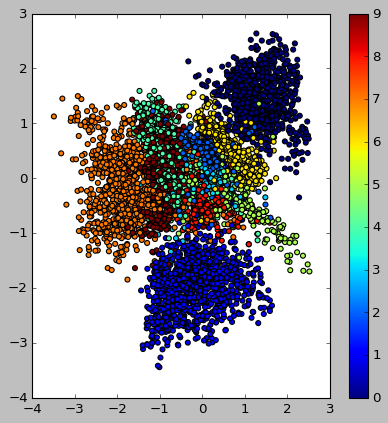

In [45]:
# Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:
x_test_encoded = encoder.predict(x_test, batch_size=32)
temp = x_test_encoded[0]
plt.style.use('classic')
plt.figure(figsize=(6, 6))
plt.scatter(temp[:, 0], temp[:, 1], c=y_test)
plt.colorbar()
plt.show()